# Genesis Potential




    IN: 

        -absolute vorticity 850hPa (uv)

        -vertical shear 850hPa to 200hPa (w)

        -RH at 600hP

        -potential intensity tcpypi

        NCAR research data archive ERA5
    
    OUT:
        
        - Genesis potential for areas
        
Check difference between interpolating and aligning data values

# Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import matplotlib
import matplotlib.pyplot as plt
from tcpyPI import pi, cape
import datetime
import cftime
import dask
import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from tqdm import tqdm, trange
import time
import scipy
import xesmf as xe

# useful functions

In [2]:
def ATLN_box(ds, box=None):
    if box == None:
        # Bounding Box in degN and degE
        north = 3
        south = -3
        east = 360
        west = 340
        lons = slice(west, east)
    else:
        # custom bounding box
        west, east, south, north = box
    t_i = datetime.datetime(1958, 1, 1)
    t_f = datetime.datetime(2019, 12, 31)
    corrected=False
    min_lon = ds.lon[0]
    
    if west < min_lon:
        west += 360
    if east < min_lon:
        east += 360

    if east < west:
        ds = ds.where(((ds.lon > west) | (ds.lon < east)))
    else:
        ds = ds.sel(lon=slice(west, east))
        
#     if south < 0:
#         ds = ds.where(((ds.latitude > south) | (ds.latitude < north)), drop=True)
#     else:
#         ds = ds.sel(latitude=slice(south, north))
    
    return ds.sel(time=slice(t_i, t_f), lat=slice(south, north))

    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# start PBSCluster

In [5]:
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='15GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=15GB', # Specify resources
    project='P93300313', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/acruz/dask_and_casper/proxy/44180/status'})

# Setup your client
client = Client(cluster)

/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38912 instead
  warnings.warn(
/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respecte

In [4]:
client

<Client: 'tcp://10.12.206.55:38753' processes=1 threads=1, memory=13.97 GiB>

# Import Data

In [6]:
# change all variables in each dataset to float64 to ensure numba runs
u = xr.open_dataset('Data/JRA55_033_ugrd.nc', chunks={'time': 12}).astype('float64')
v = xr.open_dataset('Data/JRA55_034_vgrd.nc', chunks={'time': 12}).astype('float64')
rv = xr.open_dataset('Data/JRA55_043_relv.nc', chunks={'time': 12}).astype('float64')
rh = xr.open_dataset('Data/JRA55_052_rh.nc', chunks={'time': 12}).astype('float64')
tmp = xr.open_dataset('Data/JRA55_011_tmp.nc', chunks={'time': 12}).astype('float64')
mix = xr.open_dataset('Data/JRA55_051_spfh.nc', chunks={'time': 12}).astype('float64')
mslp = xr.open_dataset('Data/JRA55_002_prmsl.nc', chunks={'time': 12}).astype('float64')
sst = xr.open_dataset('Data/hadisst.187001-201912.nc',chunks={'time': 12}).astype('float64')

/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [7]:
# using original hadisst1 data
# convert to datetime for use with jra55
sst['time'] = pd.to_datetime(sst['time'], yearfirst=True, format='%Y%m')

# old code
# datetimeindex = sst.indexes['time'].to_datetimeindex()
# sst['time'] = datetimeindex
# sst

In [23]:
# # not necessary since xesmf integration
# sst = sst.rename_dims({'lat': 'latitude', 'lon': 'longitude'}).rename_vars({'lat': 'latitude', 'lon': 'longitude'})

In [8]:
# regrid and aligment to the same coordinates using xesmf
# set coordinates (same as AN index code)
grid = 1.25
lons = np.arange(0, 360+grid, grid)
lats = np.arange(-90, 90 + grid, grid)

grid_in = {"lon": tmp.longitude.values, "lat": tmp.latitude.values}
grid_out = {"lon" : lons, "lat": lats}
grid2 = {"lon": sst.lon.values, "lat": sst.lat.values}

re_1to125 = xe.Regridder(grid2, grid_out, "bilinear", periodic=True)
regridder = xe.Regridder(grid_in, grid_out, "bilinear", periodic=True)
regridder, re_1to125  # print basic regridder information.

(xESMF Regridder 
 Regridding algorithm:       bilinear 
 Weight filename:            bilinear_145x288_145x289_peri.nc 
 Reuse pre-computed weights? False 
 Input grid shape:           (145, 288) 
 Output grid shape:          (145, 289) 
 Periodic in longitude?      True,
 xESMF Regridder 
 Regridding algorithm:       bilinear 
 Weight filename:            bilinear_180x360_145x289_peri.nc 
 Reuse pre-computed weights? False 
 Input grid shape:           (180, 360) 
 Output grid shape:          (145, 289) 
 Periodic in longitude?      True)

In [9]:
u = regridder(u).compute()
v = regridder(v).compute()
rv = regridder(rv).compute()
rh = regridder(rh).compute()
tmp = regridder(tmp).compute()
mix = regridder(mix).compute()
mslp = regridder(mslp).compute()
sst = re_1to125(sst).compute()

/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8/site-packages/xesmf/frontend.py:595: UserWarning: Using dimensions ('latitude', 'longitude') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(
/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8/site-packages/xesmf/frontend.py:595: UserWarning: Using dimensions ('latitude', 'longitude') from data variable v as the horizontal dimensions for the regridding.
  warnings.warn(
/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8/site-packages/xesmf/frontend.py:595: UserWarning: Using dimensions ('latitude', 'longitude') from data variable vo as the horizontal dimensions for the regridding.
  warnings.warn(
/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8/site-packages/xesmf/frontend.py:595: UserWarning: Using dimensions ('latitude', 'longitude') from data variable r as the horizontal dimensions for the regridding.
  warnings.warn(
/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8

In [ ]:
# # sort by coordinates not necessary since integration of xesmf
# coord_names = ['latitude', 'longitude']
# u = u.sortby(coord_names)
# v = v.sortby(coord_names)
# rv = rv.sortby(coord_names)
# rh = rh.sortby(coord_names)
# tmp = tmp.sortby(coord_names)
# mix = mix.sortby(coord_names)
# mslp = mslp.sortby(coord_names)
# sst = sst.sortby(coord_names)

# selec coords

0N to 40N and 0W to 100W 

In [10]:
box = [-100, 20, -20, 40]
rv_box = ATLN_box(rv, box).compute()
rh_box = ATLN_box(rh, box).compute()
tmp_box = ATLN_box(tmp, box).compute()
u_box = ATLN_box(u, box).compute()
v_box = ATLN_box(v, box).compute()
mix_box = ATLN_box(mix, box).compute()
mslp_box = ATLN_box(mslp, box).compute()
sst_box = ATLN_box(sst, box).compute()

# select levels

In [11]:
# define pressure levels for PI
pressure_box = u_box['isobaricInhPa']
# select levels of data
u850 = u_box.sel(isobaricInhPa=850)
v850 = v_box.sel(isobaricInhPa=850)
u200 = u_box.sel(isobaricInhPa=200)
v200 = v_box.sel(isobaricInhPa=200)
rh700 = rh_box.sel(isobaricInhPa=700)
rv850 = rv_box.sel(isobaricInhPa=850)

# calculate absolute vorticity

In [12]:
# earths rotation
omega = 7.2921 * 1e-5 #rad/s
vor_abs_850 = rv850 + 2 * omega * np.sin(np.deg2rad(rv850.lat))

# calculate shear between layers

In [13]:
# shear between components
u_shear = u850 - u200
v_shear = v850 - v200

# magnitude of shear horizontal dimension
shear = np.sqrt(u_shear.u.values ** 2 + v_shear.v.values ** 2)

# calculate PI

## Test TCpyPI with example code our datasets

In [14]:
# # Convert mixing ration to g/kg
# mix_box = mix_box * 1000

# #  convert tmp to C
# tmp_box = tmp_box - 273.15

# # convert msl to hPa
# mslp_box = mslp_box / 100

In [15]:
# # choose a location and month
# want_lat = 20
# want_lon = 360 - 30.
# want_date = datetime.datetime(2000, 7, 1)

# # get the profile and input values
# p1 = pressure_box.values
# t1 = tmp_box.sel(latitude=want_lat, longitude=want_lon, time=want_date, method='nearest').t.values
# q1 = mix_box.sel(latitude=want_lat, longitude=want_lon, time=want_date, method='nearest').q.values
# sst1 = sst_box.sel(latitude=want_lat, longitude=want_lon, time=want_date, method='nearest').values
# msl1 = mslp_box.sel(latitude=want_lat, longitude=want_lon, time=want_date, method='nearest').msl.values

In [16]:
# plt.figure()
# plt.plot(t1,p1,lw=4)
# plt.ylim([0,1000])
# plt.gca().invert_yaxis()
# #plt.yscale('log')
# plt.ylabel('Pressure (hPa)')
# plt.xlabel('Temperature (C)')
# plt.grid()
# plt.show()

In [17]:
# (VMAX,PMIN,IFL,TO,LNB) = pi(sst1, msl1, p1, t1, q1, miss_handle=1)
# print(VMAX, PMIN, IFL, TO, LNB)

In [18]:
# tmp_box

## Iterative PI calculation

In [19]:
sst_box

<xarray.Dataset>
Dimensions:  (time: 744, lat: 49, lon: 289)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * lat      (lat) float64 -20.0 -18.75 -17.5 -16.25 ... 36.25 37.5 38.75 40.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 356.2 357.5 358.8 360.0
Data variables:
    sst      (time, lat, lon) float64 22.37 22.1 21.85 21.73 ... nan nan nan nan
Attributes:
    regrid_method:  bilinear

In [20]:
# for date in tmp_box.time:
# results dataset
shape = (744, 49, 289)
dims = ('time', 'lat', 'lon')
ds = xr.Dataset(data_vars={'VMAX': (dims, np.zeros(shape), {'Description': "Maximum surface wind speed reduced to reflec surface drag.", 'units': 'm/s'}), 
                           'PMIN': (dims, np.zeros(shape), {'Description': "Minimum central pressure.", 'units': 'hPa'}), 
                           'IFL': (dims, np.zeros(shape, dtype=int), {'Description': "A value of 1 means OK; \
                                                                      a value of 0 indicates no convergence; \
                                                                      a value of 2 means that the CAPE routine failed to converge; \
                                                                      a value of 3 means the CAPE routine failed due to \
                                                                      missing data in the inputs"}), 
                           'TO': (dims, np.zeros(shape), {'Description': "Outflow temperature.", 'units': "K"}),
                           'LNB': (dims, np.zeros(shape), {'Description': "the outflow temperature level, defined as the level of neutral bouyancy \
                                                                           where the outflow temperature is found, i.e. where buoyancy is actually equal \
                                                                           to zero under the condition of an air parcel that is saturated at sea level pressure",
                                                          'units': "hPa"
                                                          }
                                  )
                          },
                coords=sst_box.coords,
                attrs={'Description': "Calculated tropical cyclone potential intensity"}
               )
p = np.asarray(pressure_box)
ds

<xarray.Dataset>
Dimensions:  (time: 744, lat: 49, lon: 289)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * lat      (lat) float64 -20.0 -18.75 -17.5 -16.25 ... 36.25 37.5 38.75 40.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 356.2 357.5 358.8 360.0
Data variables:
    VMAX     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PMIN     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    IFL      (time, lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    TO       (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    LNB      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Description:  Calculated tropical cyclone potential intensity

In [21]:
sst_box, 

<xarray.Dataset>
Dimensions:  (time: 744, lat: 49, lon: 289)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * lat      (lat) float64 -20.0 -18.75 -17.5 -16.25 ... 36.25 37.5 38.75 40.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 356.2 357.5 358.8 360.0
Data variables:
    sst      (time, lat, lon) float64 22.37 22.1 21.85 21.73 ... nan nan nan nan
Attributes:
    regrid_method:  bilinear

In [36]:
shape = [744, 49, 289]
VMAX = np.zeros(shape)
PMIN = np.zeros(shape)
IFL = np.zeros(shape)
TO = np.zeros(shape)
LNB = np.zeros(shape)
t = tmp_box.t.values - 273.15
q = mix_box.q.values
sst = sst_box.sst.values
msl = mslp_box.msl.values
p = pressure_box.values

In [37]:
# point = {'latitude': lat, 'longitude': lon, 'time': date}
# date = datetime.datetime(2000, 10, 1)
for k in tqdm(range(sst_box.time.shape[0])):
    for i in range(sst_box.lat.shape[0]):
        for j in range(sst_box.lon.shape[0]):
            if sst[k, i, j] == np.nan:
                VMAX[k, i, j] = np.nan
                PMIN[k, i, j] = np.nan
                IFL[k, i, j] = np.nan
                TO[k, i, j] = np.nan 
                LNB[k, i, j] = np.nan
                break;    
            VMAX[k, i, j], PMIN[k, i, j], IFL[k, i, j], TO[k, i, j], LNB[k, i, j] = pi(sst[k, i, j], 
                                                                                       msl[k, i, j], 
                                                                                       p, 
                                                                                       t[k, :, i, j], 
                                                                                       q[k, :, i, j])
            # commented code is much slower
            # t = tmp_box.sel(latitude=lat, longitude=lon, time=date, method='nearest').t.values
            # q = mix_box.sel(latitude=lat, longitude=lon, time=date, method='nearest').q.values
            # sst = sst_box.sel(latitude=lat, longitude=lon, time=date, method='nearest').sst.values
            # msl = mslp_box.sel(latitude=lat, longitude=lon, time=date, method='nearest').msl.values
            # VMAX[k, i, j], PMIN[k, i, j], IFL[k, i, j], TO[k, i, j], LNB[k, i, j] = pi(sst, msl, p, t, q)
            # ds.VMAX.loc[lat, lon, date], ds.PMIN.loc[lat, lon, date], ds.IFL.loc[lat, lon, date], ds.TO.loc[lat, lon, date], ds.LNB.loc[lat, lon, date] = pi(sst, msl, p, t, q)
            # pi(sst, msl, p, t, q)

100%|██████████| 744/744 [58:25<00:00,  4.71s/it] 


In [49]:
ds['VMAX'] = (dims, VMAX)
ds['PMIN'] = (dims, PMIN)
ds['IFL'] = (dims, IFL)
ds['TO'] = (dims, TO)
ds['LNB'] = (dims, LNB)
ds.to_netcdf("Data/PI_results.nc", format='NETCDF4')

# calculate GP
## as defined in Emmanuel and Nolan 2004

In [41]:
PI = xr.open_dataset('Data/PI_results.nc', format='NETCDF4')
VMAX = PI.VMAX.values

In [42]:
vor_abs_850.vo.shape
dims = ('time', 'lat', 'lon')

In [43]:
vor = dask.array.from_array(vor_abs_850.vo.values, chunks=(12, 33, 79))
H = dask.array.from_array(rh700.r.values, chunks=(12, 33, 79))
V_pot = dask.array.from_array(VMAX, chunks=(12, 33, 79))
V_shear = dask.array.from_array(shear, chunks=(12, 33, 79))

In [44]:
I = (np.sqrt(np.abs(10 ** 5 * vor)) ** 3) * ((H / 50) ** 3) * ((V_pot / 70) ** 3) * ((1 + 0.1 * V_shear) ** (-2))
GP = I.compute()

/glade/u/home/acruz/.conda/envs/TC_GP-env/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 321.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [45]:
result = xr.DataArray(GP,
                      coords=sst_box.coords,
                      dims=dims,
                      name="GP",
                      attrs={'Description': "GP results from TC_GP.ipynb scripts."})
result

<xarray.DataArray 'GP' (time: 744, lat: 49, lon: 289)>
array([[[1.10897547e-03, 1.04160257e-03, 1.15495368e-03, ...,
         1.16943697e-03, 1.21035892e-03, 1.10897547e-03],
        [9.28844084e-04, 9.82337810e-04, 1.33290586e-03, ...,
         1.06596812e-03, 1.05238562e-03, 9.28844084e-04],
        [1.40969052e-03, 1.71119337e-03, 2.11192146e-03, ...,
         1.22381659e-03, 1.33769716e-03, 1.40969052e-03],
        ...,
        [7.34893229e-02, 1.08262794e-01, 1.54192411e-01, ...,
                    nan, 6.56224090e-02, 7.34893229e-02],
        [9.06448389e-02, 1.10040884e-01, 1.41946515e-01, ...,
                    nan,            nan, 9.06448389e-02],
        [           nan, 1.34125596e-01, 1.27504194e-01, ...,
                    nan,            nan,            nan]],

       [[3.02078517e-03, 1.96199007e-03, 2.29409451e-03, ...,
         6.55872917e-03, 4.91368030e-03, 3.02078517e-03],
        [8.87447206e-03, 5.97820714e-03, 6.86156154e-03, ...,
         1.88026592e-02, 1.50369777e-02, 8.87447206e-03],
        [2.77128085e-02, 1.55007307e-02, 1.55256154e-02, ...,
         3.63562841e-02, 3.94559767e-02, 2.77128085e-02],
...
        [4.01660870e-01, 7.21103997e-01, 9.46826641e-01, ...,
                    nan, 2.22141714e-01, 4.01660870e-01],
        [4.72425753e-01, 6.97076536e-01, 1.02466418e+00, ...,
                    nan,            nan, 4.72425753e-01],
        [           nan, 8.38814595e-01, 8.69461368e-01, ...,
                    nan,            nan,            nan]],

       [[9.41272927e-04, 9.79434634e-04, 1.15943061e-03, ...,
         7.46085672e-04, 8.89262823e-04, 9.41272927e-04],
        [1.30663997e-03, 1.48438232e-03, 1.73894438e-03, ...,
         9.70474177e-04, 1.18343406e-03, 1.30663997e-03],
        [1.97625195e-03, 2.11635459e-03, 2.05581289e-03, ...,
         1.36209396e-03, 1.73896238e-03, 1.97625195e-03],
        ...,
        [1.46641072e-02, 2.19434223e-02, 2.64430354e-02, ...,
                    nan, 1.20693578e-02, 1.46641072e-02],
        [1.39269955e-02, 2.21840729e-02, 3.38278843e-02, ...,
                    nan,            nan, 1.39269955e-02],
        [           nan, 2.74303412e-02, 3.75671312e-02, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * lat      (lat) float64 -20.0 -18.75 -17.5 -16.25 ... 36.25 37.5 38.75 40.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 356.2 357.5 358.8 360.0
Attributes:
    Description:  GP results from TC_GP.ipynb scripts.

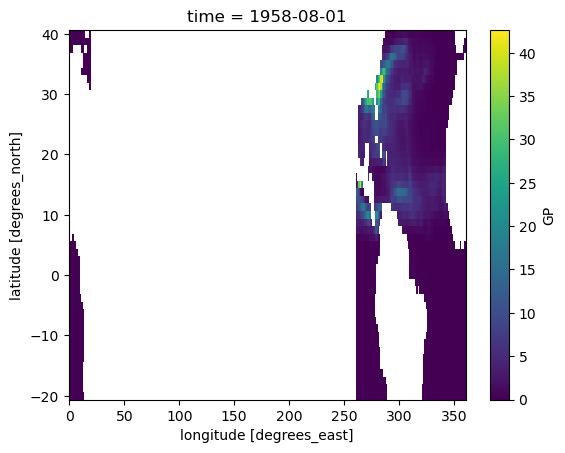

In [46]:
result[7].plot()

In [47]:
result.to_netcdf("Data/GP_results.nc", format='NETCDF4')